# Linear regression

You have probably encountered the most basic form of regression: fitting a straight line to data points $(x_i,y_i)$ in the $xy$-plane. In this we assume a relation

$$
y \approx f(x) = ax + b,
$$

and define a **loss function** or *misfit function* that adds up how far predictions are from the data:

$$
L(a,b) = \sum_{i=1}^n (f(x_i)-y_i)^2 = \sum_{i=1}^n (a x_i+b-y_i)^2.
$$

This problem can be solved by a little multidimensional calculus. If we hold $b$ fixed and take a derivative with respect to $a$, then

$$
\pp{L}{a} = \sum_{i=1}^n 2x_i(a x_i + b - y_i) = 2 a \left(\sum_{i=1}^n x_i^2\right) + 2b\left(\sum_{i=1}^n x_i\right) - \sum_{i=1}^n y_i.
$$

Similarly, if we hold $a$ fixed and differentiate with respect to $b$, then 

$$
\pp{L}{b} = \sum_{i=1}^n 2(a x_i + b - y_i) = 2 a \left(\sum_{i=1}^n x_i\right) + 2bn - \sum_{i=1}^n y_i.
$$

Setting both derivatives to zero creates a system of two linear equations to be solved for $a$ and $b$. 

Before moving on, we adopt a vector-oriented view of the process. As a sum of squares, the loss function can be written as a 2-norm:

$$
L(a,b) =  \twonorm{a \bfx + b \bfe - \bfy}^2,
$$

where $\bfe$ is a vector of $n$ ones. Minimizing $L$ over all values of $a$ and $b$ is called the **least squares** problem. (More specifically, this setup is called *simple least squares* or *ordinary least squares*.)

## Performance metrics

We need to establish ways to measure regression performance. Unlike with binary classification, in regression it's not just a matter of "right" and "wrong" answers. 

Suppose a regressor is represented by the function $f(x)$. We let $(x_i,y_i)$ for $i=1,\ldots,m$ be the test set, which may be different from the training set. 

The quantities $y_i-f(x_i)$ are known as **residuals** of the approximation, although they are often called *errors* as well, confusingly enough.

### MSE

A natural metric is the **mean squared error**,

$$
\frac{1}{m} \sum_{i=1}^m [y_i - f(x_i)]^2.
$$

If the training and test sets are the same, then the MSE is minimized by the standard regression algorithm. A closely related measure is the **mean absolute error**,

$$
\frac{1}{m} \sum_{i=1}^m |y_i - f(x_i)|,
$$

which is less sensitive to large outlier errors. 

While easy to understand, these error measurements are dimensional and depend on the scaling of the variables. 

### Coefficient of determination

The **coefficient of determination** is denoted $R^2$ and defined as

$$
1 - \frac{\sum_{i=1}^m [y_i - f(x_i)]^2}{\sum_{i=1}^m [y_i - \bar{y}]^2},
$$

where $\bar{y}$ is the mean of the target value over the test set. This quantity is dimensionless and therefore independent of scaling. A perfect regressor has an $R^2$ value of 1, while a baseline regressor that always predicts $\bar{y}$ would have $R^2=0$. 

An interpretation of the definition in words is that $R^2$ is the fraction of the variance in the true labels that is echoed by the variance in the regressor's predictions. When $R^2<1$, we say that the data has *unexplained variance* not accounted for by the regressor.

The notation is unfortunate, because $R^2$ can actually be negative! Such a result indicates that the regressor is doing worse than the baseline constant mean value prediction. However, if $f$ is the result of a standard linear regression, and if the test set is the training set, then $R^2$ equals the square of the Pearson correlation coefficient between the true and predicted values and is therefore between 0 and 1.

## Case study: Arctic ice

Let's import data about the extent of sea ice in the Arctic circle, collected monthly since 1979.

In [1]:
import pandas as pd
ice = pd.read_csv("sea-ice.csv")
ice.columns = [s.strip() for s in ice.columns]   # simplify names
ice

,year,mo,data-type,region,extent,area
0,1979,1,Goddard,N,15.41,12.41
1,1980,1,Goddard,N,14.86,11.94
2,1981,1,Goddard,N,14.91,11.91
3,1982,1,Goddard,N,15.18,12.19
4,1983,1,Goddard,N,14.94,12.01
...,...,...,...,...,...,...
513,2017,12,Goddard,N,11.74,10.26
514,2018,12,Goddard,N,11.86,10.45
515,2019,12,Goddard,N,11.90,10.52
516,2020,12,Goddard,N,11.73,10.16


A quick plot reveals something odd-looking.

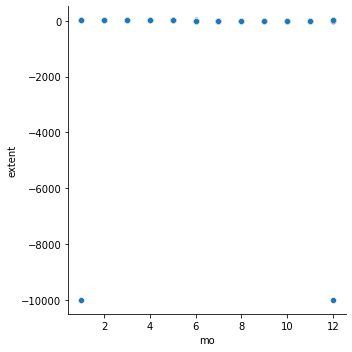

In [2]:
import seaborn as sns
sns.relplot(data=ice,x="mo",y="extent");

Everything in the plot is dominated by two large negative values. These probably represent missing or unreliable data, so we remove those rows.

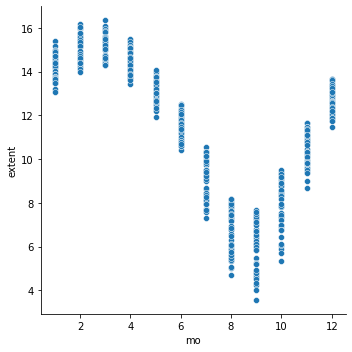

In [3]:
ice = ice[ice["extent"]>0]
sns.relplot(data=ice,x="mo",y="extent");

Each dot represents one measurement, and they are grouped by month. As you would expect, the extent of ice rises in the winter and falls in summer.

In [4]:
bymo = ice.groupby("mo")
bymo["extent"].mean()

mo
1     14.214762
2     15.100233
3     15.256977
4     14.525581
5     13.117442
6     11.539767
7      9.097907
8      6.793256
9      5.993488
10     7.887907
11    10.458182
12    12.664419
Name: extent, dtype: float64

While the effect of the seasonal variation somewhat cancels out over time when fitting a line, it's sensible to remove this obvious trend before the fit takes place. We will add a column that measures the relative change from the mean in each month.

/var/folders/cn/8w40979d27x0kv2wsnx7zgvm0000gp/T/ipykernel_64051/4253492415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ice["detrended"] = bymo["extent"].transform(lambda x: x/x.mean() - 1)


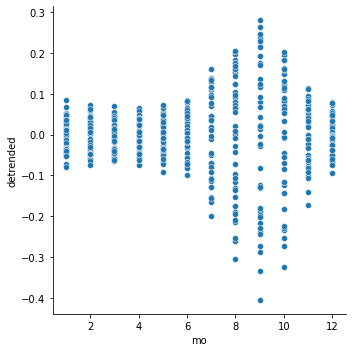

In [5]:
ice["detrended"] = bymo["extent"].transform(lambda x: x/x.mean() - 1)
sns.relplot(data=ice,x="mo",y="detrended")

An `lmplot` in seaborn will show the best-fit line.

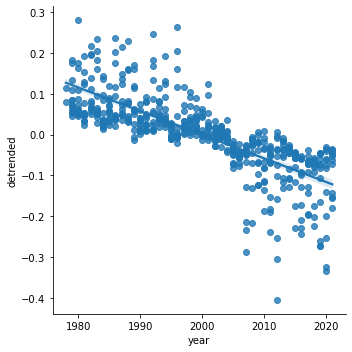

In [6]:
sns.lmplot(data=ice,x="year",y="detrended");

However, keep Simpson's paradox in mind. The previous plot showed considerably more variance in the warm months. How do the fits look for the data within each month?

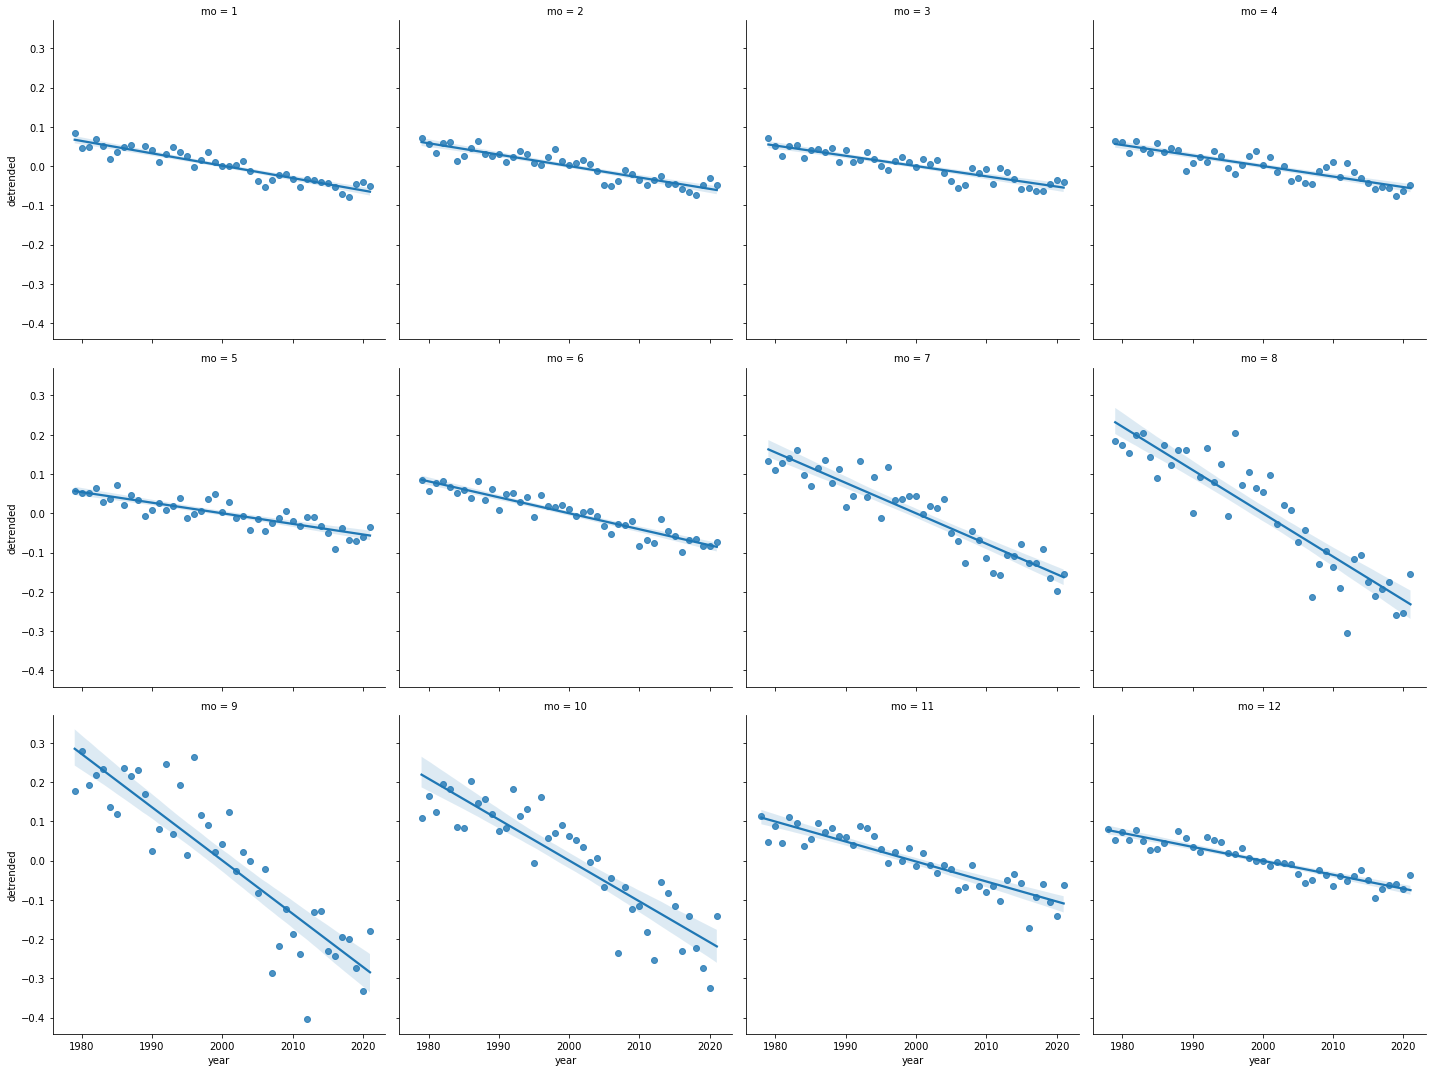

In [7]:
sns.lmplot(data=ice,x="year",y="detrended",col="mo",col_wrap=4);

While the correlation is negative in each month, the effect size is clearly larger in the summer. 

We can get numerical information about a regression line by using a `LinearRegression()` in sklearn. We will focus on the data for August.

In [8]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

aug = ice["mo"]==8
X = pd.DataFrame(ice.loc[aug,"year"])
y = ice.loc[aug,"detrended"]
lm.fit(X,y)

LinearRegression()

We can get the slope and $y$-intercept of the regression line from the learner's properties.

In [9]:
(lm.coef_,lm.intercept_)

(array([-0.01103658]), 22.07316493030779)

The slope indicates a loss of 1% per year. (Big oof.) Here, we assess the performance on the training set. The `score` method of the regressor object computes the coefficient of determination.

In [10]:
from sklearn.metrics import mean_squared_error
R2 = lm.score(X,y)
yhat = lm.predict(X)
mse = mean_squared_error(y,yhat)

print("MSE:",mse)
print("variance in data:",y.var())
print("R-squared:",R2)

MSE: 0.004013897553371555
variance in data: 0.023314236588503352
R-squared: 0.8237357450183896


An $R^2$ value this close to 1 would usually be considered a sign of a good fit, although we have not tested for generalization to new data.